In [1]:
import sys
from pprint import pprint

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
sys.path.append('..') 
from tune_sklearn import TuneSearchCV

In [3]:
def fetch_adult_data():
    from sklearn.datasets import  fetch_openml
    openml_ds = fetch_openml(data_id=179, as_frame=True, parser='pandas')
    dataset = openml_ds['frame']
    return dataset

In [4]:
dataset = fetch_adult_data()

print(dataset.shape)

dataset.sample(10)

(48842, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native-country,class
32216,2,Private,265097,HS-grad,9,Married-civ-spouse,Other-service,Husband,White,Male,0,3,2,United-States,>50K
45997,1,Private,184245,9th,5,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,3,Columbia,<=50K
7245,2,Federal-gov,40955,Some-college,10,Never-married,Other-service,Own-child,White,Male,0,0,2,Japan,<=50K
40547,1,Private,408208,HS-grad,9,Never-married,Machine-op-inspct,Not-in-family,Black,Male,0,0,1,United-States,<=50K
10153,1,Private,196044,Some-college,10,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,3,United-States,<=50K
24177,1,Private,281540,Some-college,10,Married-civ-spouse,Tech-support,Husband,White,Male,0,0,3,United-States,<=50K
44797,1,Private,145242,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,White,Female,2,0,0,United-States,>50K
41954,4,Private,203313,7th-8th,4,Divorced,Sales,Not-in-family,White,Female,0,0,2,United-States,<=50K
7612,0,Private,95918,9th,5,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,2,United-States,<=50K
15785,3,Private,370119,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,3,United-States,>50K


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             48842 non-null  category
 1   workclass       46043 non-null  category
 2   fnlwgt          48842 non-null  int64   
 3   education       48842 non-null  category
 4   education-num   48842 non-null  int64   
 5   marital-status  48842 non-null  category
 6   occupation      46033 non-null  category
 7   relationship    48842 non-null  category
 8   race            48842 non-null  category
 9   sex             48842 non-null  category
 10  capitalgain     48842 non-null  category
 11  capitalloss     48842 non-null  category
 12  hoursperweek    48842 non-null  category
 13  native-country  47985 non-null  category
 14  class           48842 non-null  category
dtypes: category(13), int64(2)
memory usage: 1.4 MB


In [6]:
dataset.isna().sum()

age                  0
workclass         2799
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        2809
relationship         0
race                 0
sex                  0
capitalgain          0
capitalloss          0
hoursperweek         0
native-country     857
class                0
dtype: int64

In [7]:
dataset.describe()

,fnlwgt,education-num
count,4.884200e+04,48842.000000
mean,1.896641e+05,10.078089
std,1.056040e+05,2.570973
min,1.228500e+04,1.000000
25%,1.175505e+05,9.000000
50%,1.781445e+05,10.000000
75%,2.376420e+05,12.000000
max,1.490400e+06,16.000000


In [8]:
dataset['class'].value_counts()

class
<=50K    37155
>50K     11687
Name: count, dtype: int64

In [9]:
dataset.drop_duplicates(keep='first', inplace=True)
dataset[dataset.duplicated()]

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native-country,class


<Axes: xlabel='race'>

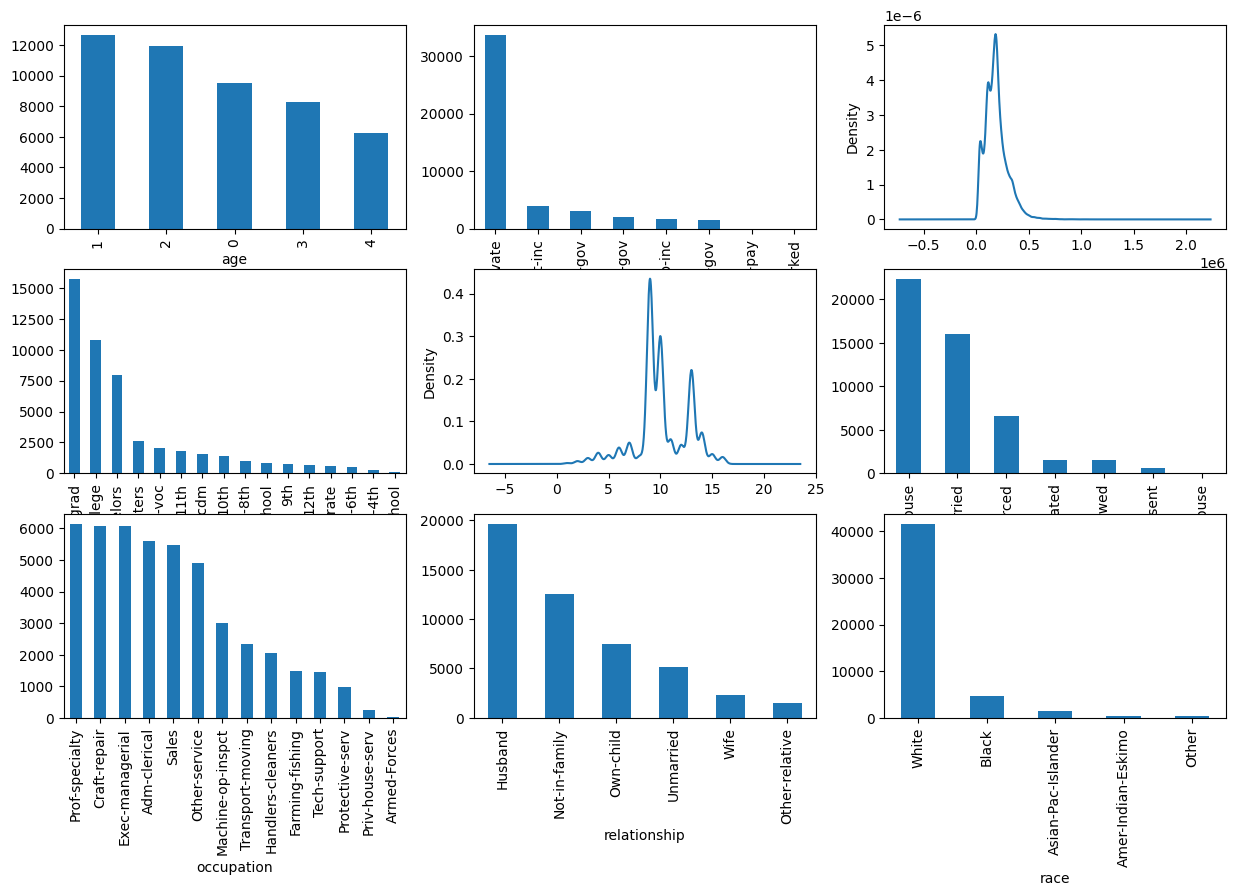

In [10]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 9))

dataset['age'].value_counts().plot(kind='bar',ax=axes[0][0])
dataset['workclass'].value_counts().plot(kind='bar',ax=axes[0][1]) 
dataset['fnlwgt'].plot(kind='kde', ax=axes[0][2])

dataset['education'].value_counts().plot(kind='bar', ax=axes[1][0]) 
dataset['education-num'].plot(kind='kde', ax=axes[1][1])
dataset['marital-status'].value_counts().plot(kind='bar', ax=axes[1][2]) 

dataset['occupation'].value_counts().plot(kind='bar', ax=axes[2][0]) 
dataset['relationship'].value_counts().plot(kind='bar', ax=axes[2][1]) 
dataset['race'].value_counts().plot(kind='bar', ax=axes[2][2]) 

<Axes: xlabel='class'>

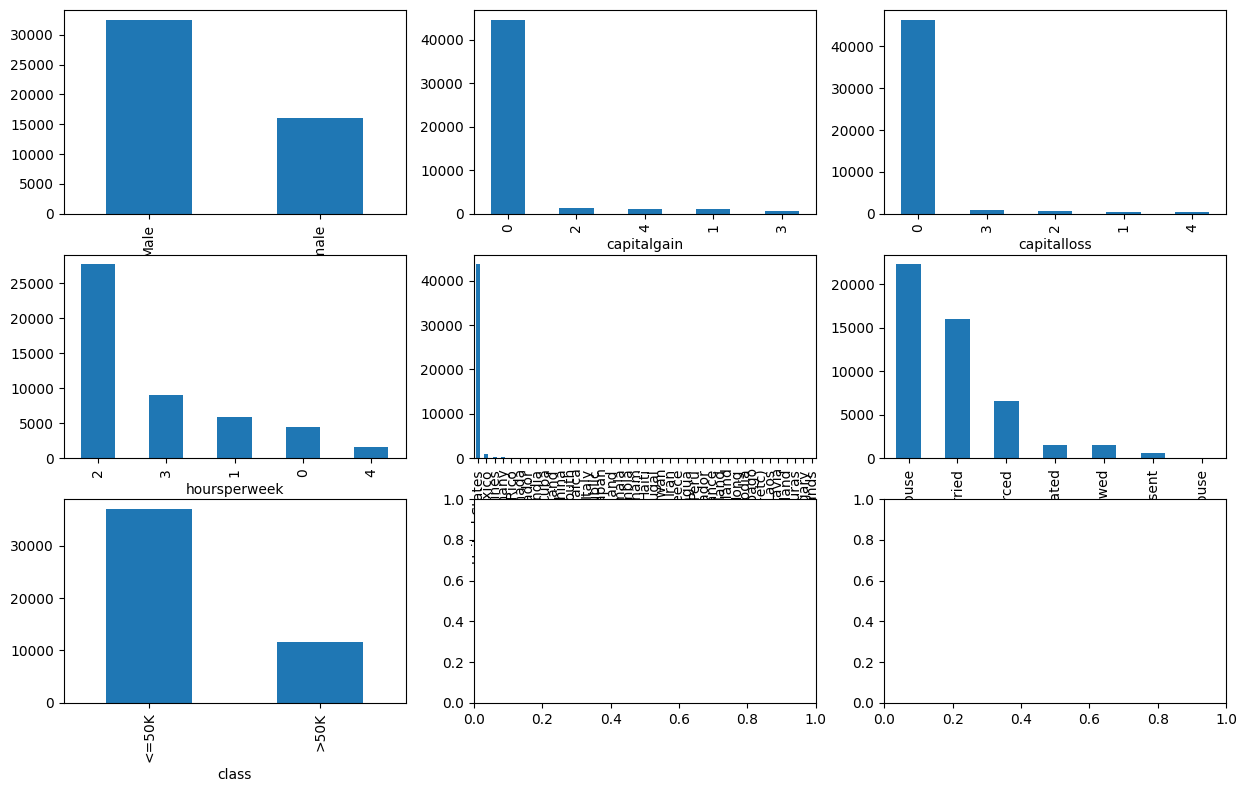

In [11]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 9))

dataset['sex'].value_counts().plot(kind='bar',ax=axes[0][0])
dataset['capitalgain'].value_counts().plot(kind='bar',ax=axes[0][1]) 
dataset['capitalloss'].value_counts().plot(kind='bar', ax=axes[0][2])

dataset['hoursperweek'].value_counts().plot(kind='bar', ax=axes[1][0]) 
dataset['native-country'].value_counts().plot(kind='bar', ax=axes[1][1])
dataset['marital-status'].value_counts().plot(kind='bar', ax=axes[1][2]) 

dataset['class'].value_counts().plot(kind='bar', ax=axes[2][0]) 


In [12]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector as column_selector

#from mlxtend.feature_selection import ColumnSelector

from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer,  OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

import tempfile

from optuna.distributions import FloatDistribution, IntDistribution, CategoricalDistribution, IntUniformDistribution
from optuna.integration import OptunaSearchCV

(48655, 14) (48655,)


In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dataset, 
                                                    target, 
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    stratify=target)

In [15]:

verbose_ = True
n_jobs_=10
transformer_n = Pipeline(
    steps=[("imputer_n", SimpleImputer(strategy="mean")), 
           # ("scaler_n", StandardScaler())
          ],
    verbose = verbose_,
    #memory= memory_
)

transformer_c = Pipeline(
    steps=[
        ("imputer_c", SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ("encoder_c", OrdinalEncoder(handle_unknown="use_encoded_value",
                                     dtype=np.int8, 
                                     encoded_missing_value=-1,
                                     unknown_value=-1)
        ),
    ],
    verbose = verbose_,
    #memory= memory_
)

def bool_to_number(x: np.ndarray) -> np.ndarray:
    return np.multiply(x, 1)

BooleanTransformer = FunctionTransformer(bool_to_number, feature_names_out = 'one-to-one')

transformer_b = Pipeline(
    steps=[("to_int", BooleanTransformer), 
           ("imputer_c", SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
          ],
    verbose = verbose_,
    #memory= memory_
)

preprocessor = ColumnTransformer(
    transformers=[
        ("transformer_n", transformer_n, column_selector(dtype_include=[np.number]) ),
        ("transformer_c", transformer_c, column_selector(dtype_include=["category"]) ),
        ("transformer_b", transformer_b, column_selector(dtype_include=[bool]) ),
    ],
    n_jobs = n_jobs_,
    remainder='drop',
    verbose_feature_names_out=False,
    verbose=verbose_
).set_output(transform='pandas')

args = {
    "random_state": 10,
    "n_jobs": n_jobs_,
}

model = Pipeline(
    steps=[("transformer", preprocessor ), 
           ("estimator", RandomForestClassifier(**args))
          ],
    verbose = verbose_,
    #memory = memory_
)
           


In [16]:
from ray import tune

from sklearn.model_selection._search import BaseSearchCV
from sklearn.model_selection import check_cv
from sklearn.base import is_classifier
from sklearn.base import clone
from sklearn.metrics import check_scoring
from sklearn.exceptions import NotFittedError
import multiprocessing

import ray

In [17]:
cv = check_cv(cv=5, y=y_train, classifier=is_classifier(model))
n_splits = cv.get_n_splits(X_train, y_train, None)
available_cpus = multiprocessing.cpu_count()

scorers = {"score": check_scoring(model, scoring=None)}

In [18]:
cv,n_splits,available_cpus,scorers

(StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
 5,
 12,
 {'score': <sklearn.metrics._scorer._PassthroughScorer at 0x1bda363d6d0>})

In [19]:
#available_cpus = ray.cluster_resources().get('CPU', None)
#available_gpus = ray.cluster_resources().get('GPU', None)

In [20]:
#available_cpus, available_gpus

In [21]:
config = {}
n_jobs = n_jobs_
cv=5
config["early_stopping"] = None
config["early_stop_type"] = None
config["groups"] = None
config["cv"] = cv
config["scoring"] = scorers
config["max_iters"] = n_jobs
config["return_train_score"] = True
config["n_jobs"] = -1
config["metric_name"] = 'average_test_score'
config["error_score"] = 'raise'

In [22]:
from optuna.samplers import TPESampler
from ray.tune.search.optuna import OptunaSearch
from optuna.distributions import BaseDistribution, FloatDistribution, IntDistribution, CategoricalDistribution

param_distributions = {
    "estimator__n_estimators": IntDistribution(10, 300, step=10),
    "estimator__max_depth": IntDistribution(1, 11),
    "estimator__min_impurity_decrease": FloatDistribution(0.000000001, 0.5, log=True),
    "estimator__max_features": FloatDistribution(0.4, 1),
    "estimator__max_features": CategoricalDistribution([1.0, "sqrt", "log2"]),
    "estimator__bootstrap": CategoricalDistribution([True, False]),
}



In [23]:
from ray.tune.search.sample import Domain

all(isinstance(v, Domain) for k, v in param_distributions.items() )


False

In [24]:
np.ceil(6/2)


3.0

In [41]:
from ray.tune.stopper import MaximumIterationStopper
from ray.tune.logger import (
    Logger,
    JsonLoggerCallback,
    CSVLoggerCallback,
    TBXLoggerCallback,
    LegacyLoggerCallback,
    LoggerCallback,
)

max_iter=1
n_trials=40
use_gpu = False
stopper = MaximumIterationStopper(max_iter=max_iter)

if n_jobs < 0:
    resources_per_trial = {"cpu": 1, "gpu": 1 if use_gpu else 0}
else:
    available_cpus = multiprocessing.cpu_count()
    gpu_fraction = 1 if use_gpu else 0
    if ray.is_initialized():
        available_cpus = ray.cluster_resources()["CPU"]
        if use_gpu:
            available_gpus = ray.cluster_resources()["GPU"]
            gpu_fraction = available_gpus / n_jobs
    cpu_fraction = available_cpus / n_jobs
    cpu_fraction = int(np.ceil(cpu_fraction)) if cpu_fraction > 1 else cpu_fraction
    gpu_fraction = int(np.ceil(gpu_fraction)) if gpu_fraction > 1 else gpu_fraction
    resources_per_trial = {"cpu": cpu_fraction, "gpu": gpu_fraction}    
    
print(resources_per_trial)    

run_args = dict(
            scheduler=None,
            reuse_actors=True,
            verbose=3,
            stop=stopper,
            num_samples=n_trials,
            config=config,
            fail_fast="raise",
            resources_per_trial=resources_per_trial,
            local_dir=None,
            name=None,
            callbacks=[JsonLoggerCallback()],
            time_budget_s=None,
            metric='average_test_score',
            mode='max',
        )

search_kwargs = {
}
search_kwargs["metric"] = run_args.pop("metric")
search_kwargs["mode"] = run_args.pop("mode")
search_kwargs["sampler"] = TPESampler(seed=10)
search_algo = OptunaSearch(space=param_distributions, **search_kwargs)
run_args["search_alg"] = search_algo




[I 2024-01-15 19:07:18,931] A new study created in memory with name: optuna


{'cpu': 2, 'gpu': 0}


In [37]:
from sklearn.model_selection import cross_validate
from sklearn.utils.metaestimators import _safe_split
from sklearn.model_selection._validation import _score, check_cv, is_classifier
from sklearn.base import clone
import numpy as np
import os
from pickle import PicklingError
import warnings
import traceback
import inspect

from ray.tune import Trainable
import ray.cloudpickle as cpickle

from enum import Enum, auto

class EarlyStopping(Enum):
    PARTIAL_FIT = auto()
    WARM_START_ITER = auto()
    WARM_START_ENSEMBLE = auto()
    XGB = auto()
    LGBM = auto()
    CATBOOST = auto()
    NO_EARLY_STOP = auto()

class SK_Trainable(Trainable):
    """Class to be passed in as the first argument of tune.run to train models.

    Overrides Ray Tune's Trainable class to specify the setup, train, save,
    and restore routines.

    """

    estimator_list = None

    @property
    def main_estimator(self):
        return self.estimator_list[0]

    def setup(self, config, X=None, y=None, estimator_list=None, fit_params=None):
        # forward-compatbility
        self.X = X
        self.y = y
        self.original_estimator_list = estimator_list
        self.fit_params = fit_params
        self._setup(config)

    def _setup(self, config):
        """Sets up Trainable attributes during initialization.

        Also sets up parameters for the sklearn estimator passed in.

        Args:
            config (dict): contains necessary parameters to complete the `fit`
                routine for the estimator. Also includes parameters for early
                stopping if it is set to true.

        """
        self.early_stopping = config.pop("early_stopping")
        self.early_stop_type = config.pop("early_stop_type")
        self.groups = config.pop("groups")
        self.scoring = config.pop("scoring")
        self.max_iters = config.pop("max_iters")
        self.return_train_score = config.pop("return_train_score")
        self.n_jobs = config.pop("n_jobs")
        self.metric_name = config.pop("metric_name", "average_test_score")
        self.error_score = config.pop("error_score", "raise")
        self.estimator_config = config
        self.train_accuracy = None
        self.test_accuracy = None
        self.saved_models = []  # XGBoost specific

        self.estimator_list = [clone(est) for est in self.original_estimator_list]

        self.cv = check_cv(
            config.pop("cv"), self.y, classifier=is_classifier(self.main_estimator)
        )

        if self.early_stopping:
            n_splits = self._setup_early_stopping()

            for i in range(n_splits):
                self.estimator_list[i].set_params(**self.estimator_config)

            if self.early_stop_type in (
                EarlyStopping.XGB,
                EarlyStopping.LGBM,
                EarlyStopping.CATBOOST,
            ):
                self.saved_models = [None for _ in range(n_splits)]
        else:
            self.main_estimator.set_params(**self.estimator_config)

    def _setup_early_stopping(self):
        n_splits = self.cv.get_n_splits(self.X, self.y, groups=self.groups)
        self.fold_scores = np.empty(n_splits, dtype=dict)
        self.fold_train_scores = np.empty(n_splits, dtype=dict)
        if self.early_stop_type == EarlyStopping.WARM_START_ITER:
            # max_iter here is different than the max_iters the user sets.
            # max_iter is to make sklearn only fit for max_iter/max_iters
            # epochs, while max_iters (which the user can set) is the usual
            # max number of calls to _trainable.
            self.estimator_config["warm_start"] = True
            self.estimator_config["max_iter"] = (
                self.main_estimator.max_iter // self.max_iters
            )

        elif self.early_stop_type == EarlyStopping.WARM_START_ENSEMBLE:
            # Each additional call on a warm start ensemble only trains
            # new estimators added to the ensemble. We start with 0
            # and add self.resource_step estimators before each call to fit
            # in _train(), training the ensemble incrementally.
            self.resource_step = self.main_estimator.n_estimators // self.max_iters
            self.estimator_config["warm_start"] = True
            self.estimator_config["n_estimators"] = 0

        return n_splits

    def step(self):
        # forward-compatbility
        return self._train()

    def _early_stopping_partial_fit(self, i, estimator, X_train, y_train):
        """Handles early stopping on estimators that support `partial_fit`."""
        if "classes" in inspect.getfullargspec(estimator.partial_fit).args:
            estimator.partial_fit(X_train, y_train, classes=np.unique(self.y))
        else:
            estimator.partial_fit(X_train, y_train)

    
    def _early_stopping_iter(self, i, estimator, X_train, y_train):
        """Handles early stopping on estimators supporting `warm_start`."""
        estimator.fit(X_train, y_train)

    

    def _train(self):
        """Trains one iteration of the model called when ``tune.run`` is called.

        Different routines are run depending on if the ``early_stopping``
        attribute is True or not.

        If ``self.early_stopping`` is not None, each fold is fit with
        `partial_fit`, which stops training the model if the validation
        score is not improving for a particular fold.

        Otherwise, run the full cross-validation procedure.

        In both cases, the average test accuracy is returned over all folds,
        as well as the individual folds' accuracies as a dictionary.

        Returns:
            ret (:obj:`dict): Dictionary of results as a basis for
                ``cv_results_`` for one of the cross-validation interfaces.

        """
        fit_failed = False
        if self.early_stopping:
            print('Error')
        else:
            try:
                try:
                    scores = cross_validate(
                        self.main_estimator,
                        self.X,
                        self.y,
                        cv=self.cv,
                        n_jobs=10 , #self.n_jobs,
                        fit_params=self.fit_params,
                        groups=self.groups,
                        scoring=self.scoring,
                        return_train_score=self.return_train_score,
                        error_score=self.error_score,
                        verbose=0
                    )
                except PicklingError:
                    warnings.warn(
                        "An error occurred in parallelizing the cross "
                        "validation. Proceeding to cross validate with "
                        "one core."
                    )
                    scores = cross_validate(
                        self.main_estimator,
                        self.X,
                        self.y,
                        cv=self.cv,
                        fit_params=self.fit_params,
                        groups=self.groups,
                        scoring=self.scoring,
                        return_train_score=self.return_train_score,
                        error_score=self.error_score,
                    )
            except ValueError as e:
                if "It is very likely that your model is misconfigured" not in str(e):
                    raise e
                fit_failed = True

            if fit_failed:
                # If all folds fail, sklearn will raise an error, even
                # if error_score is not set to "raise".
                # We want to fail gracefully instead by setting
                # everything to error score.
                fake_test_scores = {
                    f"test_{name}": [self.error_score]
                    * self.cv.get_n_splits(self.X, self.y, self.groups)
                    for name in self.scoring
                }
                if self.return_train_score:
                    fake_train_scores = {
                        f"train_{name}": [self.error_score]
                        * self.cv.get_n_splits(self.X, self.y, self.groups)
                        for name in self.scoring
                    }
                else:
                    fake_train_scores = {}
                scores = {**fake_test_scores, **fake_train_scores}

            ret = {}
            for name in self.scoring:
                for i, score in enumerate(scores["test_%s" % name]):
                    key_str = f"split{i}_test_%s" % name
                    ret[key_str] = score
                self.test_accuracy = sum(scores["test_%s" % name]) / len(
                    scores["test_%s" % name]
                )
                ret["average_test_%s" % name] = self.test_accuracy

            if self.return_train_score:
                for name in self.scoring:
                    for i, score in enumerate(scores["train_%s" % name]):
                        key_str = f"split{i}_train_%s" % name
                        ret[key_str] = score
                    self.train_accuracy = sum(scores["train_%s" % name]) / len(
                        scores["train_%s" % name]
                    )
                    ret["average_train_%s" % name] = self.train_accuracy

        ret["objective"] = ret.get(self.metric_name)

        return ret

    def save_checkpoint(self, checkpoint_dir: str):
        # forward-compatbility
        self._save(checkpoint_dir)

    def _save(self, checkpoint_dir):
        """Creates a checkpoint in ``checkpoint_dir``, creating a pickle file.

        Args:
            checkpoint_dir (str): file path to store pickle checkpoint.

        Returns:
            path (str): file path to the pickled checkpoint file.

        """
        path = os.path.join(checkpoint_dir, "checkpoint")
        try:
            with open(path, "wb") as f:
                cpickle.dump(self.estimator_list, f)
        except Exception:
            warnings.warn("Unable to save estimator.", category=RuntimeWarning)

    def load_checkpoint(self, checkpoint_dir: str):
        # forward-compatbility
        self._restore(checkpoint_dir)

    def _restore(self, checkpoint_dir):
        """Loads a checkpoint created from `save`.

        Args:
            checkpoint (str): file path to pickled checkpoint file.

        """
        path = os.path.join(checkpoint_dir, "checkpoint")
        try:
            with open(path, "rb") as f:
                self.estimator_list = cpickle.load(f)
        except Exception:
            warnings.warn("No estimator restored", category=RuntimeWarning)

    def reset_config(self, new_config):
        self.config = new_config
        self._setup(new_config)
        return True

In [42]:
from ray import tune
from sklearn.base import clone
from sklearn.pipeline import make_pipeline
import joblib
from ray.util import joblib as ray_joblib 


ray_joblib.register_ray()

trainable = SK_Trainable

from joblib import Memory

#dirpath = tempfile.mkdtemp()
dirpath = 'C:\\Users\\rdas6\\OneDrive\\Desktop\\codespace\\Python\\Machine-Learning_handson\\temporary_dir' 

model_ = clone(model)
memory_ = Memory(location=None, verbose=10, backend='ray')
model_.memory = memory_

estimator_list = [model_]

trainable = tune.with_parameters(
            trainable, X=X_train, y=y_train, estimator_list=estimator_list, fit_params=None
        )

In [43]:
estimator_list[0]

Pipeline(memory=Memory(location=None),
         steps=[('transformer',
                 ColumnTransformer(n_jobs=10,
                                   transformers=[('transformer_n',
                                                  Pipeline(steps=[('imputer_n',
                                                                   SimpleImputer())],
                                                           verbose=True),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001BDA6BFAF70>),
                                                 ('transformer_c',
                                                  Pipeline(steps=[('imputer_c',
                                                                   SimpleImputer(strategy='most_frequent'...
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function bool_to_number at 0x000001BDA3638160>)),
                                                                  ('imputer_c',
                                                                   SimpleImputer(strategy='most_frequent'))],
                                                           verbose=True),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001BDA6BA3D60>)],
                                   verbose=True,
                                   verbose_feature_names_out=False)),
                ('estimator',
                 RandomForestClassifier(n_jobs=10, random_state=10))],
         verbose=True)

In [44]:
import warnings
import time

st_time = time.time()
if ray.is_initialized():
    ray.shutdown()
ray.init()

try:
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message="fail_fast='raise' " "detected.")
        analysis = tune.run(trainable, **run_args)
except Exception as err:
    print(err)
finally:    
    memory_.clear()
    ray.shutdown()

print(f'End 2 End  Time - {time.time() - st_time} secs')    
analysis    

2024-01-15 19:07:26,632	INFO worker.py:1724 -- Started a local Ray instance.
2024-01-15 19:07:27,933	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Trial name,average_test_score,average_train_score,date,done,hostname,iterations_since_restore,node_ip,objective,pid,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,time_since_restore,time_this_iter_s,time_total_s,timestamp,training_iteration,trial_id
SK_Trainable_0707f92a,0.774818,0.77519,2024-01-15_19-08-32,True,Rahul_PC,1,127.0.0.1,0.774818,9780,0.774181,0.775234,0.776493,0.774848,0.77675,0.774784,0.773539,0.775394,0.773124,0.77569,30.9032,30.9032,30.9032,1705325912,1,0707f92a
SK_Trainable_0b503964,0.760302,0.760302,2024-01-15_19-07-34,True,Rahul_PC,1,127.0.0.1,0.760302,17572,0.760308,0.760301,0.760308,0.760301,0.760308,0.760301,0.760308,0.760301,0.760277,0.760308,4.261,4.261,4.261,1705325854,1,0b503964
SK_Trainable_0fc73253,0.838737,0.839874,2024-01-15_19-09-16,True,Rahul_PC,1,127.0.0.1,0.838737,6692,0.843931,0.839109,0.842646,0.839109,0.83738,0.840618,0.835838,0.8402,0.83389,0.840334,44.813,44.813,44.813,1705325956,1,0fc73253
SK_Trainable_12ff46cd,0.851454,0.863375,2024-01-15_19-09-43,True,Rahul_PC,1,127.0.0.1,0.851454,13080,0.854078,0.861492,0.853565,0.863772,0.850867,0.864125,0.849069,0.864832,0.849692,0.862653,30.9466,30.9466,30.9466,1705325983,1,12ff46cd
SK_Trainable_14abcf84,0.852456,0.869843,2024-01-15_19-10-50,True,Rahul_PC,1,127.0.0.1,0.852456,8244,0.855877,0.867433,0.854592,0.869488,0.85228,0.870356,0.848683,0.871736,0.850848,0.870199,31.0695,31.0695,31.0695,1705326050,1,14abcf84
SK_Trainable_1a693efb,0.849733,0.857729,2024-01-15_19-09-45,True,Rahul_PC,1,127.0.0.1,0.849733,6692,0.853051,0.855647,0.852408,0.859372,0.850096,0.857959,0.846757,0.858955,0.846351,0.856712,27.192,27.192,27.192,1705325985,1,1a693efb
SK_Trainable_1bd6ab2d,0.847883,0.853477,2024-01-15_19-08-31,True,Rahul_PC,1,127.0.0.1,0.847883,18824,0.852408,0.8525,0.849711,0.852757,0.84727,0.854523,0.845601,0.854587,0.844424,0.853019,12.6225,12.6225,12.6225,1705325911,1,1bd6ab2d
SK_Trainable_22cb5005,0.85112,0.863349,2024-01-15_19-11-11,True,Rahul_PC,1,127.0.0.1,0.85112,8244,0.855363,0.862616,0.851895,0.863547,0.852408,0.864093,0.848812,0.864318,0.847122,0.862171,17.9834,17.9834,17.9834,1705326071,1,22cb5005
SK_Trainable_2f46099b,0.850606,0.863317,2024-01-15_19-11-11,True,Rahul_PC,1,127.0.0.1,0.850606,6692,0.854721,0.862744,0.85228,0.863258,0.850867,0.86419,0.848298,0.864992,0.846865,0.8614,17.362,17.362,17.362,1705326071,1,2f46099b
SK_Trainable_39672f0e,0.851968,0.870054,2024-01-15_19-10-18,True,Rahul_PC,1,127.0.0.1,0.851968,6692,0.855877,0.867497,0.855106,0.87042,0.852537,0.870741,0.84727,0.872122,0.849049,0.869493,32.8318,32.8318,32.8318,1705326018,1,39672f0e


2024-01-15 19:09:45,601	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 0.565 s, which may be a performance bottleneck.
2024-01-15 19:09:45,617	WARNING util.py:202 -- The `process_trial_result` operation took 0.581 s, which may be a performance bottleneck.
2024-01-15 19:09:45,651	WARNING util.py:202 -- Processing trial results took 0.615 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-01-15 19:09:45,651	WARNING util.py:202 -- The `process_trial_result` operation took 0.615 s, which may be a performance bottleneck.
2024-01-15 19:10:21,631	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 1.828 s, which may be a performance bottleneck.
2024-01-15 19:10:21,636	WARNING util.py:202 -- The `process_trial_result` operation took 1.834 s, which may be a performance bottleneck.
2024-01-15 19:10:21,637	WARNING util.py:202 -- Processing trial results took 1.835 s, which may be a performance bott

End 2 End  Time - 230.5256519317627 secs


In [ ]:
print(f'End 2 End  Time - {time.time() - st_time} secs')

In [60]:
import joblib
from ray.util.joblib import register_ray
dirpath = tempfile.mkdtemp()

register_ray()

if ray.is_initialized():
    ray.shutdown()
ray.init()
try:
    model_ = clone(model)
    tempdir = tempfile.TemporaryDirectory()
    with joblib.parallel_backend('ray', n_jobs=-1):
        memory_ = Memory(location=tempdir.name, verbose=10)
        model_.memory = memory_
        model_.verbose = True
        for i in range(10):
            model_.fit(X_train, y=y_train)
except Exception as err:
    print(err)
finally:    
    memory_.clear()
    ray.shutdown()
    tempdir.cleanup()


2024-01-15 19:28:24,938	INFO worker.py:1724 -- Started a local Ray instance.


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(ColumnTransformer(n_jobs=10,
                  transformers=[('transformer_n',
                                 Pipeline(steps=[('imputer_n',
                                                  SimpleImputer())],
                                          verbose=True),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001BDA81AE370>),
                                ('transformer_c',
                                 Pipeline(steps=[('imputer_c',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder_c',
                                         ..., 
      age         workclass  fnlwgt     education  education-num  \
16569   4         Local-gov   84737       HS-grad              9   
30

[Memory(location=C:\Users\rdas6\AppData\Local\Temp\tmp87jbfcr9\joblib)]: Flushing completely the cache


[Pipeline] ......... (step 2 of 2) Processing estimator, total=   5.4s


In [59]:
try:
    tempdir = tempfile.TemporaryDirectory()
    model_ = clone(model)
    memory_ = Memory(dirpath.name, verbose=10)
    model_.memory = memory_
    model_.verbose = True
    with joblib.parallel_backend('loky', n_jobs=-1):
        for i in range(40*5):
            model_.fit(X_train, y=y_train)
except Exception as err:
    print(err)
finally:    
    memory_.clear()
    tempdir.cleanup()

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(ColumnTransformer(n_jobs=10,
                  transformers=[('transformer_n',
                                 Pipeline(steps=[('imputer_n',
                                                  SimpleImputer())],
                                          verbose=True),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001BDA834BAC0>),
                                ('transformer_c',
                                 Pipeline(steps=[('imputer_c',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder_c',
                                         ..., 
      age         workclass  fnlwgt     education  education-num  \
16569   4         Local-gov   84737       HS-grad              9   
30

[Memory(location=C:\Users\rdas6\AppData\Local\Temp\tmpdlrlkn1j\joblib)]: Flushing completely the cache


[Pipeline] ......... (step 2 of 2) Processing estimator, total=   1.3s
